In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

In [2]:
from torchtext.vocab import Vocab
from collections import Counter
import json

with open("conll04_test.json") as f:
    data = json.load(f)
    
tokens = []
for datum in data:
    tokens += datum['tokens']

#vocab = Vocab(Counter(tokens), vectors="glove.6B.100d")
vocab = Vocab(Counter(tokens))

In [3]:
ENTITY_TO_ID = {"O":0,"Loc":1, "Org":2, "Peop":3, "Other":4}
REL_TO_ID = {"*":0, "Work_For_arg1":1, "Kill_arg1":2, "OrgBased_In_arg1":3, "Live_In_arg1":4,
             "Located_In_arg1":5, "Work_For_arg2":6, "Kill_arg2":7, "OrgBased_In_arg2":8,
             "Live_In_arg2":9, "Located_In_arg2":10}

class DataLoader(object):
    def __init__(self, filename, vocab, batch_size=1):
        self.batch_size = batch_size
        
        with open(filename) as f:
            data = json.load(f)
            
        self.data = self.preprocess(data, vocab)
        self.data = [self.data[i: i + batch_size] for i in range(0, len(self.data), batch_size)]
        
    def preprocess(self, data, vocab):
        
        processed = []
        for i, d in enumerate(data):
#             print(i)
            if i == 10:
                break
            tokens = to_ids([t.lower() for t in d['tokens']], vocab.stoi)

            entities = ['O'] * len(tokens)
            for e in d['entities']:
                entities[e['end']] = e['type']
            entities = to_ids(entities, ENTITY_TO_ID)

            relations = []
            for r in d['relations']:
                curr = ['*'] * len(tokens)
                curr[r['head']] = r['type'] + "_arg1"
                curr[r['tail']] = r['type'] + "_arg2"

                relations += [to_ids(curr, REL_TO_ID)]
                
            relations = relations[0]

            processed += [(tokens, entities, relations)]
                
        return processed
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, key):
        if not isinstance(key, int):
            raise TypeError
        
        if key < 0 or key >= self.__len__():
            raise IndexError
            
        return list(zip(*self.data[key]))
    
    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
def to_ids(tokens, vocab):
    """ Maps a list of tokens to the corresponding ids given by the dictionary, vocab"""

    ids = [vocab[t] if t in vocab else 0 for t in tokens]
    return ids

In [4]:
import torch

class NER_Net(torch.nn.Module):
    '''Simple Named Entity Recognition model'''

    def __init__(self, vocab_size, num_classes, hidden_dim=50, embedding_dim=100):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        # layers
        self.embedding = torch.nn.Embedding(self.vocab_size, self.embedding_dim)
        #self.embedding.weight = torch.nn.Parameter(vocab.vectors)
        self.embedding.weight.data.uniform_(-1.0, 1.0)
        
        self.lstm = torch.nn.LSTM(self.embedding_dim, self.hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(self.hidden_dim, num_classes)

        # Initialize fully connected layer
        self.fc.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.fc.weight, gain=1)

    def forward(self, s):
        s = self.embedding(s)   # dim: batch_size x batch_max_len x embedding_dim
        s, _ = self.lstm(s)     # dim: batch_size x batch_max_len x lstm_hidden_dim
        s = self.fc(s)          # dim: batch_size*batch_max_len x num_tags

        return s
    
    
class RE_Net(torch.nn.Module):
    '''Simple Relation extraction model'''

    def __init__(self, vocab_size, num_classes, hidden_dim=50, embedding_dim=100):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        # layers
        self.embedding = torch.nn.Embedding(self.vocab_size, self.embedding_dim)
        #self.embedding.weight = torch.nn.Parameter(vocab.vectors)
        self.embedding.weight.data.uniform_(-1.0, 1.0)
        
        self.lstm = torch.nn.LSTM(self.embedding_dim, self.hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(self.hidden_dim, num_classes)

        # Initialize fully connected layer
        self.fc.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.fc.weight, gain=1)

    def forward(self, s):
        s = self.embedding(s)   # dim: batch_size x batch_max_len x embedding_dim
        s, _ = self.lstm(s)     # dim: batch_size x batch_max_len x lstm_hidden_dim
        s = self.fc(s)          # dim: batch_size*batch_max_len x num_tags

        return s

In [5]:
train = DataLoader("conll04_test.json", vocab)

In [6]:
datum = train[0]
tokens = torch.tensor([[  32, 1973, 2272,   15,    3,    0,    0,    5,    0,  389,    0,   12,
            7,  823,    4, 2636,    4,    0,  114,    5,    3, 2701,    6]])
entities  =  torch.LongTensor([0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0])
relations = torch.LongTensor([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

  0%|          | 0/100 [00:00<?, ?it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


  9%|▉         | 9/100 [00:00<00:26,  3.40it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 12%|█▏        | 12/100 [00:00<00:19,  4.61it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 20%|██        | 20/100 [00:01<00:09,  8.25it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 28%|██▊       | 28/100 [00:01<00:05, 13.24it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 38%|███▊      | 38/100 [00:01<00:03, 20.60it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 49%|████▉     | 49/100 [00:01<00:01, 29.98it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 54%|█████▍    | 54/100 [00:02<00:01, 26.34it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 64%|██████▍   | 64/100 [00:02<00:01, 32.28it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 73%|███████▎  | 73/100 [00:02<00:00, 33.64it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 85%|████████▌ | 85/100 [00:02<00:00, 42.24it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


 90%|█████████ | 90/100 [00:02<00:00, 43.62it/s]

lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


100%|██████████| 100/100 [00:03<00:00, 32.42it/s]


lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))
lambda ne,re: ; return And(ForAll(Eq(ne[Eq(re,3)],2)),ForAll(Eq(ne[Eq(re,8)],1)))


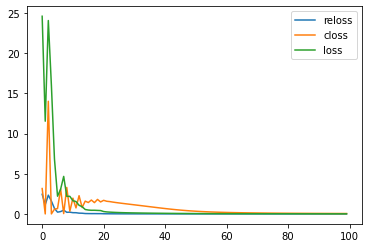

In [7]:
from tqdm import tqdm
import torch
import itertools
import torch.nn.functional as F
import sys
sys.path.append("..")

from pytorch_constraints.tnorm_solver import ProductTNormLogicSolver
from pytorch_constraints.constraint import constraint
from pytorch_constraints.brute_force_solver import *
from pytorch_constraints.sampling_solver import *

ENTITY_TO_ID = {"O":0,"Loc":1, "Org":2, "Peop":3, "Other":4}
REL_TO_ID = {"*":0, "Work_For_arg1":1, "Kill_arg1":2, "OrgBased_In_arg1":3, "Live_In_arg1":4,
             "Located_In_arg1":5, "Work_For_arg2":6, "Kill_arg2":7, "OrgBased_In_arg2":8,
             "Live_In_arg2":9, "Located_In_arg2":10}

def BigConstraint(ne, re):
    return OrgBasedIn_Org_Loc(ne, re) #and OneAndOnlyOne(re) #and Kill_Per_Per(ne, re) and WorkFor_Per_Org(ne, re)\
        #and LivesIn_Per_Loc(ne, re) and LocatedIn_Loc_Loc(ne, re) and OneAndOnlyOne(re)

# def OrgBasedIn_Org_Loc(ne, re):
    
#     arg1 = (re==3).nonzero(as_tuple=False)
#     arg2 = (re==8).nonzero(as_tuple=False)
    
#     return all(ne[arg1] == 2) and all(ne[arg2] == 1)

def OrgBasedIn_Org_Loc(ne, re): return all(ne[re==3]==2) and all(ne[re==8]==1)

def Kill_Per_Per(ne, re):
    
    arg1 = (re==2).nonzero(as_tuple=False)
    arg2 = (re==7).nonzero(as_tuple=False)
    
    return all(ne[arg1] == 3) and all(ne[arg2] == 3)
    
def WorkFor_Per_Org(ne, re):
    
    arg1 = (re==1).nonzero(as_tuple=False)
    arg2 = (re==6).nonzero(as_tuple=False)
    
    return all(ne[arg1] == 3) and all(ne[arg2] == 2)

def LivesIn_Per_Loc(ne, re):
    
    arg1 = (re==4).nonzero(as_tuple=False)
    arg2 = (re==9).nonzero(as_tuple=False)
    
    return all(ne[arg1] == 3) and all(ne[arg2] == 1)
    

def LocatedIn_Loc_Loc(ne, re):
    
    arg1 = (re==5).nonzero(as_tuple=False)
    arg2 = (re==10).nonzero(as_tuple=False)
    
    return all(ne[arg1] == 1) and all(ne[arg2] == 1)

def OneAndOnlyOne(re):
    
    pred_rel = (re!=0).nonzero(as_tuple=False)
    return len(pred_rel) == 2

# Models
ner = NER_Net(vocab_size=len(vocab), num_classes=len(ENTITY_TO_ID))
re = RE_Net(vocab_size=len(vocab), num_classes=len(REL_TO_ID))

# Optimization
opt = torch.optim.SGD(list(ner.parameters()) + list(re.parameters()), lr=1.0)

# # Plotting
plot_loss = PlotHelper()

cons = constraint(OrgBasedIn_Org_Loc, ProductTNormLogicSolver())
# cons = constraint(BigConstraint, WeightedSamplingSolver(num_samples=200))
# cons = constraint(BigConstraint, SamplingSolver(num_samples=200))

for i in tqdm(range(100)):
    opt.zero_grad()
    
    ner_logits = ner(tokens)
    ner_logits = ner_logits.view(-1, ner_logits.shape[2])
    
    re_logits = re(tokens)
    re_logits = re_logits.view(-1, re_logits.shape[2])
    
    
    ner_loss = F.cross_entropy(ner_logits, entities.view(-1))
    re_loss = F.cross_entropy(re_logits, relations.view(-1))
    closs = cons(ner_logits, re_logits)
    loss = 0.05*closs + 10*re_loss #+ ner_loss 
    
    plot_loss.add(reloss=re_loss.data, closs=closs.data, loss=loss.data)
    
    loss.backward()
    opt.step()
    
plot_loss.show()

In [8]:
torch.argmax(torch.softmax(re(tokens).view(-1, 11), dim=-1), dim=-1)

tensor([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
torch.argmax(torch.softmax(ner(tokens).view(-1, 5), dim=-1), dim=-1)